In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from scipy.signal.windows import blackman
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os

In [2]:
def get_samples(num_samples, SAVE_PATH=''):
    
    cdata = np.empty((3,num_samples), dtype=np.complex128)
    # ADC_A is channel[3], ADC_C is channel[1], ADC_D is channel[0]
    for i, j in enumerate([3,1,0]):
        cdata[i,:] = np.array(base.radio.receiver.channel[j].transfer(num_samples))
    
    if SAVE_PATH:
        np.save('data/' + SAVE_PATH, cdata)
        
    
    return cdata

def save_data(data, SAVE_PATH=''):
    np.save('data/' + SAVE_PATH, data)
    return

In [3]:
from pynq.overlays.base import BaseOverlay
import xrfdc
import xrfclk
from xrfclk.xrfclk import _read_tics_output
base = BaseOverlay('base.bit')
base.init_rf_clks()

In [30]:
_read_tics_output()
xrfclk.set_ref_clks(lmk_freq=245.76)

In [31]:
DAC_A_Freq = 1497
ADC_A_Freq = -1485.

gains = np.arange(0.25, 0.75, 0.025)

In [32]:
# DAC_A
# Not here b/c will be iterating over it in the gain loop

# DAC_B
base.radio.transmitter.channel[0].dac_block.MixerSettings['Freq'] = 0 # MHz
base.radio.transmitter.channel[0].control.gain = 0.5
base.radio.transmitter.channel[0].control.enable = False

# ADC_A
base.radio.receiver.channel[3].adc_block.MixerSettings['Freq'] = ADC_A_Freq # MHz
base.radio.receiver.channel[3].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

In [33]:
NUM_REP = 200
NUM_SAMP = 32768
DECIMATION = 2
SAMP_FREQ = 4915.2e6/DECIMATION
CHANNELS = [0] # 0=ADC_A, 1=ADC_C, 2=ADC_D

SAVE_NAME = '20250623-2_ip2_200rep_DAC1497-1485'

In [34]:
%%time

for gain in gains:
    # DAC_A - Checked, working
    base.radio.transmitter.channel[1].dac_block.MixerSettings['Freq'] = DAC_A_Freq # MHz
    base.radio.transmitter.channel[1].control.gain = gain
    base.radio.transmitter.channel[1].control.enable = True

    blackmanWindow = np.tile(blackman(NUM_SAMP), (3,1))
    freqdomain = rfftfreq(NUM_SAMP, 1/SAMP_FREQ)
    freqdata = np.zeros((3,NUM_SAMP), dtype=np.float64)

    print(f'Gain: {gain}')
    for i in range(NUM_REP):

        data = get_samples(NUM_SAMP) # complex (I,Q) in time domain
        data = np.real(data) # picks out I-data in time domain
        data *= blackmanWindow # I-data with window
        dataf = np.abs(rfft(data[CHANNELS]))
        freqdata[CHANNELS,:] += dataf

    freqdata /= NUM_REP # average over number of reps
    
    allData = np.zeros((4,NUM_SAMP), dtype=np.float64)
    allData[3,:] = freqdomain
    allData[0:3,:] = freqdata
    
    np.save('data/' + SAVE_NAME + f'gain{round(gain, 2)}', allData)
    allData = None

Gain: 0.25
Gain: 0.275
Gain: 0.30000000000000004
Gain: 0.32500000000000007
Gain: 0.3500000000000001
Gain: 0.3750000000000001
Gain: 0.40000000000000013
Gain: 0.42500000000000016
Gain: 0.4500000000000002
Gain: 0.4750000000000002
Gain: 0.5000000000000002
Gain: 0.5250000000000002
Gain: 0.5500000000000003
Gain: 0.5750000000000003
Gain: 0.6000000000000003
Gain: 0.6250000000000003
Gain: 0.6500000000000004
Gain: 0.6750000000000004
Gain: 0.7000000000000004
Gain: 0.7250000000000004
CPU times: user 32min 47s, sys: 44 s, total: 33min 32s
Wall time: 1h 26s


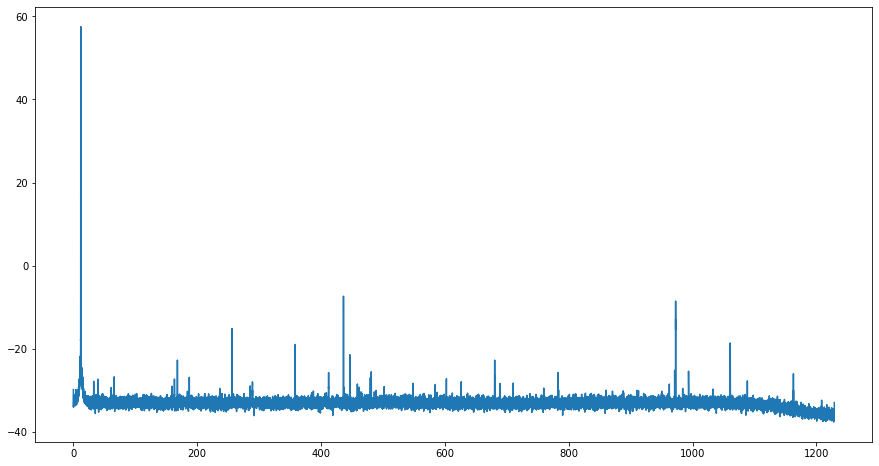

In [29]:
# freqdata = np.load(r'data/20250616-1_ip2_DAC1497-1485gain0.5.npy')
freqdata = np.load(r'data/20250623-1_ip2_DAC1497-0gain0.5.npy')
freqdomain = freqdata[-1,:]*1e-6
freqdata = freqdata[0,:]
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(freqdomain, 20*np.log10(freqdata))
fundamental = DAC_A_Freq + ADC_A_Freq
h2 = 4915.2 - 2*DAC_A_Freq + ADC_A_Freq
h3 = -2457.6 + 3*DAC_A_Freq - 1485
# ax.axvline(fundamental)
# ax.axvline(h2)
# ax.axvline(h3)
# ax.set_xlim(left=30, right=40)
plt.show()

In [80]:
data_dir = r'data/'
prefix = '20250617-1_ip2_DAC1497-0'

def get_ind(freq, SAMP_FREQ, DECIMATION, NUM_SAMP):
    return int(freq/(SAMP_FREQ/DECIMATION)*NUM_SAMP)

fundamental = DAC_A_Freq + ADC_A_Freq
h2 = 4915.2 - 2*DAC_A_Freq + ADC_A_Freq
h3 = -2457.6 + 3*DAC_A_Freq - 1485

fund_ind = get_ind(fundamental*1e6, SAMP_FREQ, DECIMATION, NUM_SAMP)
h2_ind = get_ind(h2*1e6, SAMP_FREQ, DECIMATION, NUM_SAMP)
h3_ind = get_ind(h3*1e6, SAMP_FREQ, DECIMATION, NUM_SAMP)

in_vrms = []
out_fund = []
out_h2 = []
out_h3 = []

for filename in os.listdir(data_dir):

    if not prefix in filename:
        continue

    dac_vrms = float(filename.split('gain')[-1][:-4]) / np.sqrt(2)

    freqdata = np.load(data_dir + filename)
    freqdomain = freqdata[-1,:]
    freqdata = freqdata[CHANNELS,:]

    if len(CHANNELS) == 1:
        freqdata = freqdata[0,:]

    # Normalizations to get data into V_rms
    freqdata /= NUM_SAMP
    freqdata *= 2
    freqdata /= np.sqrt(2)

    fund_vrms = np.amax(freqdata[fund_ind-5:fund_ind+5])
    h2_vrms = np.amax(freqdata[h2_ind-5:h2_ind+5])
    h3_vrms = np.amax(freqdata[h3_ind-5:h3_ind+5])

    in_vrms.append(dac_vrms)
    out_fund.append(fund_vrms)
    out_h2.append(h2_vrms)
    out_h3.append(h3_vrms)

in_vrms = np.array(in_vrms)
filesort = np.argsort(in_vrms)
in_vrms = in_vrms[filesort]
out_fund = np.array(out_fund)[filesort]
out_h2 = np.array(out_h2)[filesort]
out_h3 = np.array(out_h3)[filesort]

In [81]:
in_vrms = 20*np.log10(in_vrms)
out_fund = 20*np.log10(out_fund)
out_h2 = 20*np.log10(out_h2)
out_h3 = 20*np.log10(out_h3)

m1, b1 = np.polyfit(in_vrms, out_fund, 1)
m2, b2 = np.polyfit(in_vrms, out_h2, 1)
m3, b3 = np.polyfit(in_vrms, out_h3, 1)

print(f'Slope, fundamental: {round(m1, 3)}')
print(f'Slope, 2nd-order: {round(m2, 3)}')
print(f'Slope, 3rd-order: {round(m3, 3)}')

Slope, fundamental: 1.0
Slope, 2nd-order: 1.222
Slope, 3rd-order: -0.01


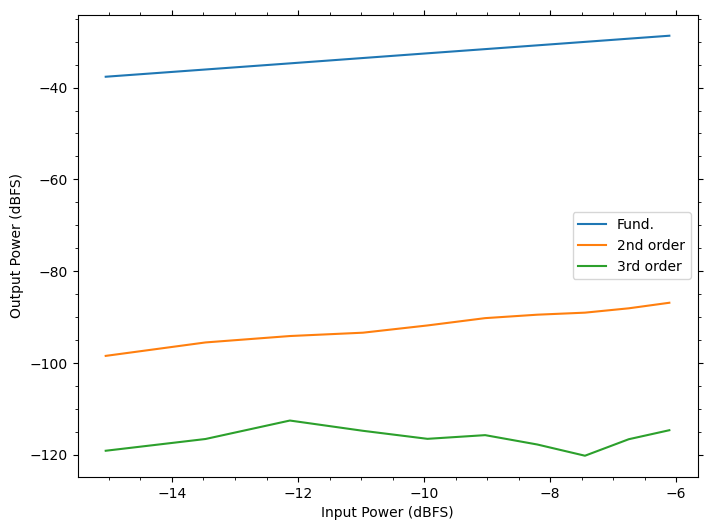

In [82]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(in_vrms, out_fund, label='Fund.')
ax.plot(in_vrms, out_h2, label='2nd order')
ax.plot(in_vrms, out_h3, label='3rd order')
ax.legend()
ax.set_xlabel('Input Power (dBFS)')
ax.set_ylabel('Output Power (dBFS)')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

In [71]:
# # Now need to convert from ADC V_rms into "real" ERASynth V_rms
# def myline(m, x):
#     return m*x

# popt = np.load('calib/gain.npy')
# vrms = myline(freqdata, *popt)

print(np.amax(freqdata))
powerdata = freqdata*freqdata/50 * 1e3 # Convert V_rms to mW, this is power of the output (i.e. power of signal measured by ADC)
print(f'Max power: {round(np.amax(powerdata), 5)} mW')


9.588651346635185e-06
Max power: 0.0 mW


[23.175 24.45  23.55  15.6   30.    15.825 26.325 18.825 26.4   17.4
 22.05  22.65  18.225 21.675 28.5   25.575 19.95  20.55  23.925 21.525
 23.7   14.025 17.55  23.55  21.3   23.475 21.225 24.225 18.075 20.4
 18.75  20.025 26.325 23.1   17.1   25.95  28.35  23.1   18.675 17.175
 18.675 24.15  27.075 26.25  14.475 27.    14.55  23.625 18.75  21.6  ]


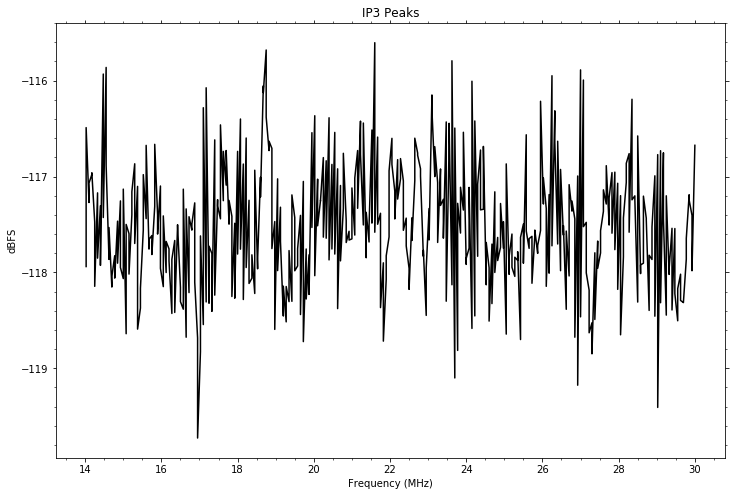

In [72]:
plotdomain = freqdomain[l_ind:r_ind]*1e-6 # Convert to MHz
maxpower = 10 # mW, this is from (1/sqrt(2))^2/50 *1e3
plotdata = np.copy(powerdata[l_ind:r_ind])/maxpower
plotdata = 10*np.log10(plotdata) # in dBFS, use 10 prefactor b/c powers


print(plotdomain[np.argsort(plotdata)][-50:])
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plotdomain, plotdata, color='black')
# ax.axvline(mixtone1, color='red')
# ax.axvline(mixtone2, color='red')
# ax.axvline(cubicmix1, color='red')
# ax.axvline(cubicmix2, color='red')
ax.set_title('IP3 Peaks')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBFS')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

In [ ]:
sublength = len(plotdata)

def get_ind_again(freq, plotdomain):
    freq -= plotdomain[0]
    freq = max(0, freq)
    domainlength = len(plotdomain)
    domainscale = plotdomain[-1] - plotdomain[0]
    return int(freq/domainscale * domainlength)

l_ind = get_ind_again((cubicmix2 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
lcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((cubicmix1 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgcubic_power = 0.5*(lcubic_power + rcubic_power)
print(f'Average h3 Power: {round(avgcubic_power,1)} dBFS')

l_ind = get_ind_again((mixtone2 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
ltone_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((mixtone1 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rtone_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgtone_power = 0.5*(ltone_power + rtone_power)
print(f'Average Fundamental Power: {round(avgtone_power,1)} dBFS')

deltaP = avgtone_power - avgcubic_power
print(f'Delta P: {round(deltaP, 1)} dB')
OIP3 = avgtone_power + 0.5*deltaP
print(f'OIP3: {round(OIP3,1)} dBFS')

popt = np.load('calib/gain.npy')
gain = 1/popt[0] # since popt[0] is slope of ERASynth V_rms vs. ADC V_rms, gain is from input->output, so 1/slope
gain = 20*np.log10(gain) # now in dB, use 20 b/c gain is associated with voltages
IIP3 = OIP3 - gain
print(f'IIP3: {round(IIP3,1)} dBFS')

Average IM3 Power: -116.6 dBFS
Average Fundamental Power: -53.0 dBFS
Delta P: 63.6 dB
OIP3: -21.2 dBFS
IIP3: -19.1 dBFS


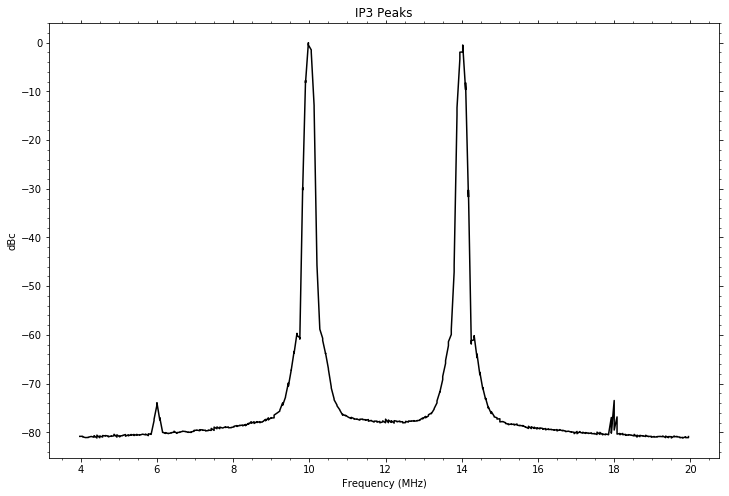

In [16]:
plotdomain = freqdomain[l_ind:r_ind]*1e-6 # Convert to MHz
maxRecPower = np.amax(powerdata)
plotdata = np.copy(powerdata[l_ind:r_ind])/maxRecPower
plotdata = 10*np.log10(plotdata) # now in dBc, use 10 prefactor b/c powers

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plotdomain, plotdata, color='black')
# ax.axvline(mixtone1, color='red')
# ax.axvline(mixtone2, color='red')
# ax.axvline(cubicmix1, color='red')
# ax.axvline(cubicmix2, color='red')
ax.set_title('IP3 Peaks')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBc')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

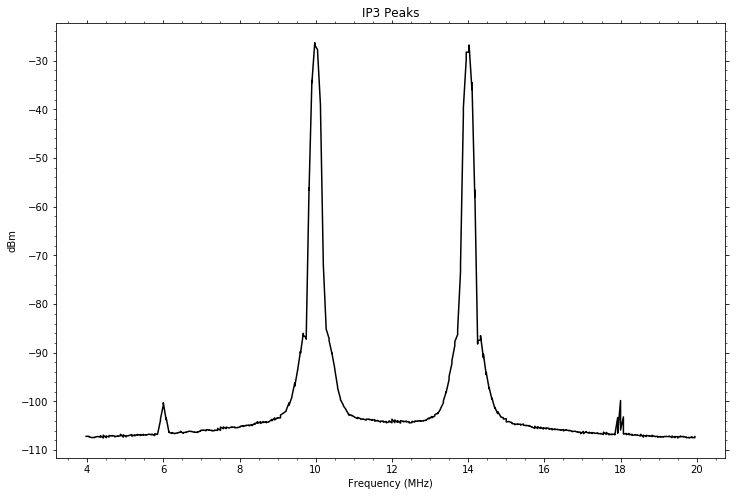

In [17]:
plotdomain = freqdomain[l_ind:r_ind]*1e-6 # Convert to MHz
plotdata = np.copy(powerdata[l_ind:r_ind])
plotdata = 10*np.log10(plotdata)        # now in dBm

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plotdomain, plotdata, color='black')
# ax.axvline(mixtone1, color='red')
# ax.axvline(mixtone2, color='red')
# ax.axvline(cubicmix1, color='red')
# ax.axvline(cubicmix2, color='red')
ax.set_title('IP3 Peaks')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBm')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

In [ ]:
sublength = len(plotdata)

def get_ind_again(freq, plotdomain):
    freq -= plotdomain[0]
    freq = max(0, freq)
    domainlength = len(plotdomain)
    domainscale = plotdomain[-1] - plotdomain[0]
    return int(freq/domainscale * domainlength)

l_ind = get_ind_again((cubicmix2 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
lcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((cubicmix1 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgcubic_power = 0.5*(lcubic_power + rcubic_power)
print(f'Average h3 Power: {round(avgcubic_power,1)} dBm')

l_ind = get_ind_again((mixtone2 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
ltone_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((mixtone1 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rtone_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgtone_power = 0.5*(ltone_power + rtone_power)
print(f'Average Fundamental Power: {round(avgtone_power,1)} dBm')

deltaP = avgtone_power - avgcubic_power
OIP3 = avgtone_power + 0.5*deltaP
print(f'OIP3: {round(OIP3,1)} dBm')

popt = np.load('calib/gain.npy')
gain = 1/popt[0] # since popt[0] is slope of ERASynth V_rms vs. ADC V_rms, gain is from input->output, so 1/slope
gain = 20*np.log10(gain) # now in dB, use 20 b/c gain is associated with voltages
IIP3 = OIP3 - gain
print(f'IIP3: {round(IIP3,1)} dBm')

Average IM3 Power: -100.0 dBm
Average Fundamental Power: -26.6 dBm
OIP3: 10.2 dBm
IIP3: 12.3 dBm


In [92]:
# Now calculating ratio of a_1 to a_3
AIIP3 = np.sqrt(50*1e-3*10**(0.1*IIP3)) # Amplitude, in V_rms, of IIP3
ratio = 0.75*AIIP3*AIIP3 # this is in Volts^2, ratio of a1 to a3
maxRecPower = np.amax(powerdata)
maxRecAmpRMS = np.sqrt(maxRecPower*1e-3*50)
relIM = 20*np.log10(0.75/ratio*maxRecAmpRMS*maxRecAmpRMS) # in dBc
print(relIM)
print(1/(10**(relIM/20)))

-76.07339945471253
6363.117937117547


In [85]:
# save_data(np.array([freqdomain, freqdata]), SAVE_PATH='20250522_IP3_avg1000reps_05gain_LPfilter')

In [7]:
num_chans = iqdata.shape[0]
num_samples = iqdata.shape[1]
print(f'{num_samples} in each of {num_chans} channel(s)')

chan_a = iqdata[0,:]
chan_c = iqdata[1,:]
chan_d = iqdata[2,:]

NameError: name 'iqdata' is not defined

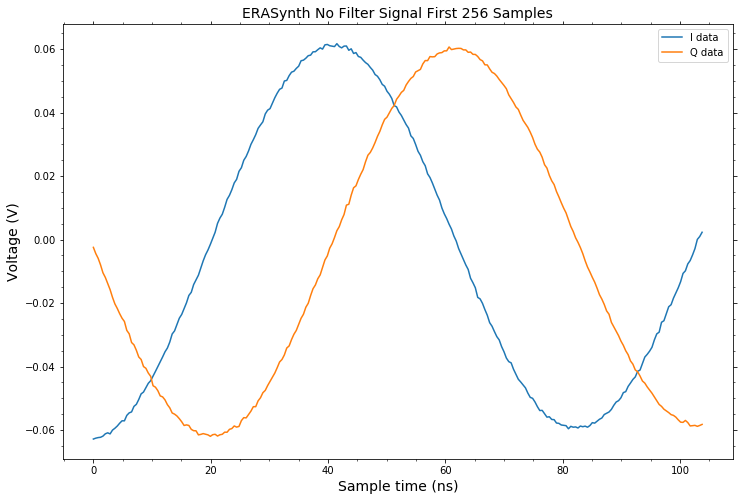

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
f_s = 2457.6e6
sample_times = np.arange(0, num_samples/f_s, 1/f_s)*1e9
idata = np.real(chan_c)
qdata = np.imag(chan_c)
ax.plot(sample_times[0:256], idata[0:256], label='I data')
ax.plot(sample_times[0:256], qdata[0:256], label='Q data')
ax.legend()
ax.set_title('ERASynth No Filter Signal First 256 Samples', fontdict=dict(size=14))
ax.set_ylabel('Voltage (V)', fontdict=dict(size=14))
ax.set_xlabel('Sample time (ns)', fontdict=dict(size=14))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

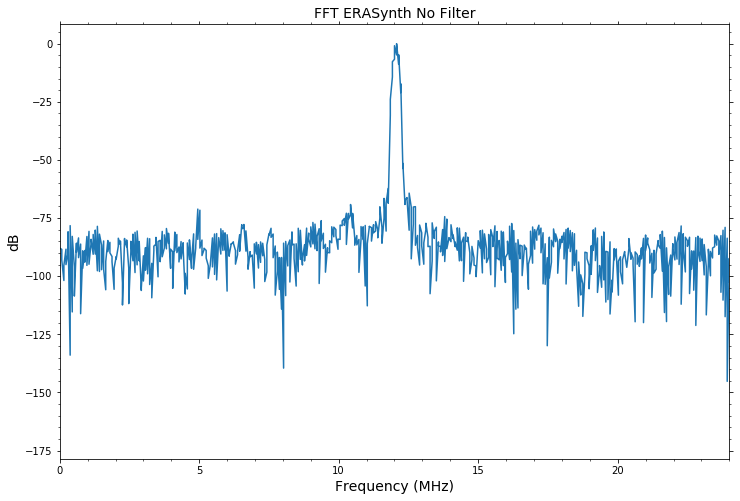

Peak frequencies:
	12.075 MHz


In [9]:
blackman_window = blackman(num_samples)
idata_f = np.abs(rfft(blackman_window*idata))
idata_f = idata_f/np.amax(idata_f)
idata_f = 20*np.log10(idata_f)
freqs = rfftfreq(num_samples, 1/f_s)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(freqs*1e-6, idata_f)
ax.set_xlim(0,24)
ax.set_title('FFT ERASynth No Filter', fontdict=dict(size=14))
ax.set_ylabel('dB', fontdict=dict(size=14))
ax.set_xlabel('Frequency (MHz)', fontdict=dict(size=14))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
# ax.text(30,0,'Sig$_1$, LO$_1$', fontdict=dict(size=12))
# ax.text(90,-18,'Sig$_3$, LO$_3$', fontdict=dict(size=12))
# ax.text(160,-28,'Sig$_5$, LO$_5$', fontdict=dict(size=12))
# ax.text(950,-48,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
# ax.text(1020,-34,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
# ax.text(1170,-35,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
plt.minorticks_on()
plt.show()

peak_indices = find_peaks(idata_f, height=-60, distance=10)[0]
print('Peak frequencies:')
for peak_index in peak_indices:
    print(f'\t{round(freqs[peak_index]*1e-6, 3)} MHz')

NameError: name 'base' is not defined